In [1]:
import breizhcrops
from breizhcrops import BreizhCrops
import contextily as ctx
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from breizhcrops.datasets.breizhcrops import BANDS as allbands
from torch.utils.data import DataLoader
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from scipy.interpolate import interp1d
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, Bidirectional
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
from IPython.display import display
from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model

In [ ]:
#IMPORT

In [54]:
def raw_transform(input_timeseries):
    return input_timeseries

In [4]:
data1 = BreizhCrops(region="frh01", transform=raw_transform, level="L2A")
data2 = BreizhCrops(region="frh02", transform=raw_transform, level="L2A")
data3 = BreizhCrops(region="frh03", transform=raw_transform, level="L2A")
data4 = BreizhCrops(region="frh04", transform=raw_transform, level="L2A")

In [ ]:
#DATAFRAME CREATION

In [55]:
def simplify_structure(array):
    if isinstance(array, np.ndarray) and array.shape == (1,) and isinstance(array[0], np.ndarray):
        return array[0]
    return array
    
def dataframe_creation(data):
    dataindex = data.index
    datadf = dataindex
    datadf['time_series'] = [None] * len(datadf)

    for i in range(len(datadf)):        
        time_series, _, _ = data[i]
        datadf.iloc[i, datadf.columns.get_loc('time_series')] = [time_series] #formatting issue: solved by making it a list
        
    if isinstance(datadf.columns, pd.MultiIndex):
        datadf.columns = ['_'.join(map(str, col)).rstrip('_') for col in datadf.columns.values]
    print("dataframe created")
    
    datadf.rename(columns={'Unnamed: 0': 'old_idx'}, inplace=True) #rename to old_idx bc its same as idx which we drop
    datadf.reset_index(drop=True, inplace=True) #no idx, so new indexing
    
    datadf['time_series'] = datadf['time_series'].apply(np.array) #we want time_series to be an array, not a list
    
#time_series are unnecessarily wrapped so to fix we return inner array: 
    datadf['time_series'] = datadf['time_series'].apply(simplify_structure)
    print("simplified")
    return datadf

#creating dataframe by joining data.index and time_series
#bc the idx column and the rest are on different axes, we flatten by joining level names

In [ ]:
data1df = dataframe_creation(data1)
print("data1 digested")
data1df.to_pickle('data1df_1.pkl')
print("Pickle 1")

data2df = dataframe_creation(data2)
print("data2 digested")
data2df.to_pickle('data2df_1.pkl')
print("Pickle 2")

data3df = dataframe_creation(data3)
print("data3 digested")
data3df.to_pickle('data3df_1.pkl')
print("Pickle 3")

data4df = dataframe_creation(data4)
print("data4 digested")
data4df.to_pickle('data4df_1.pkl')
print("Pickle 4")

In [57]:
target_length = 45 #target_length is decided by looking at the minimum, 45 in paper, 40 in transform github

In [56]:
def _3d_check(df):
    feature_sizes = set()
    non_3d_entries = []
    print(count)
    for index, series in df['time_series'].items():
        if series is not None:
            if series.ndim == 3:
                feature_sizes.add(series.shape[1])
            else:
                non_3d_entries.append(index)
    print("Unique sizes of the second dimension:", feature_sizes)
    if non_3d_entries:
        print("Entries that are not 3-dimensional are at indices:", non_3d_entries)
    else:
        print("All entries are 3-dimensional.")

#Bc the minimum is so low, I will interpolate them so that I can have sequence length of 45 afterwards

In [ ]:
data1df["time_series"].iloc[0].shape #3D bc of wrapper while creating

In [58]:
def _2d_check(df):
    feature_sizes = set()
    non_2d_entries = []
    for index, series in df['time_series'].items():
        if series is not None:
            if series.ndim == 2:
                feature_sizes.add(series.shape[0])
            else:
                non_2d_entries.append(index)
    print("Unique sizes of the second dimension:", feature_sizes)
    if non_2d_entries:
        print("Entries that are not 2-dimensional are at indices:", non_2d_entries)
    else:
        print("All entries are 2-dimensional.")


In [ ]:
#SUBSAMPLE IF LONGER THAN 45

In [59]:
def subsample_time_series(time_series):#randomly sub-sample each time series to a number of target_length observations
    for sequences in time_series:
        num_observations = len(sequences)    

        if num_observations <= target_length: #if <= 45, leave it be
            sequences = sequences[sequences[:, 0].argsort()] #should already be sorted, just in case
            return sequences

        #if > 45, subsample down to 45
        indices = np.random.choice(num_observations, target_length, replace=False)
        sequences = sequences[indices]
        sequences = sequences[sequences[:, 0].argsort()] #first element is unixtime, order accordingly
    return sequences

In [ ]:
#INTERPOLATE IF SHORTER THAN 45

In [60]:
def interpolate_time_series(arrays):
    original_length = len(arrays)
    
    if original_length < target_length:
        times = arrays[:, 0]
        spectral_data = arrays[:, 1:]

        needed_new_times = target_length - original_length

        # Generate appropriate new timestamps, no overlap with original
        full_times = np.linspace(times.min(), times.max(), num=target_length)
        new_times = np.setdiff1d(full_times, times)[:needed_new_times]


        interp_func = interp1d(times, spectral_data, kind='linear', axis=0, fill_value="extrapolate")

        # Interpolate only at new times
        if needed_new_times > 0:
            new_spectral_data = interp_func(new_times)
            new_full_data = np.column_stack((new_times, new_spectral_data))
            combined_data = np.vstack((arrays, new_full_data))
        else:
            combined_data = arrays


        sorted_data = combined_data[np.argsort(combined_data[:, 0])]
        arrays = sorted_data

    return arrays

In [61]:
def update_seqlength(sequencelength):  #update sequence lengths
    return target_length

In [62]:
def fix_timeseries(dataframe): #also makes time_series 2D
    print("Before subsampling: ")
    _3d_check(dataframe)
    dataframe['time_series'] = dataframe['time_series'].apply(subsample_time_series)
    print("After subsampling: ")
    _d_check(dataframe)
    dataframe['time_series'] = dataframe['time_series'].apply(interpolate_time_series)
    print("After interpolation: ")
    _2d_check(dataframe)
    dataframe['sequencelength'] = dataframe['sequencelength'].apply(update_seqlength)
    print(dataframe.head())
    return dataframe

        

In [ ]:
#PICKLE BC DATAFRAMES ARE REALLY BIG

In [ ]:

data1df = dataframe(data1df)
print("Done 1")
data1df.to_pickle('data1df_2.pkl')
print("Pickle 1")
data2df = dataframe(data2df)
print("Done 2")
data2df.to_pickle('data2df_2.pkl')
print("Pickle 2")
data3df = dataframe(data3df)
print("Done 3")
data3df.to_pickle('data3df_2.pkl')
print("Pickle 3")
data4df = dataframe(data4df)
print("Done 4")
data4df.to_pickle('data4df_2.pkl')
print("Pickle 4")


In [17]:
data1df = pd.read_pickle("data1df_2.pkl")
data2df = pd.read_pickle("data2df_2.pkl") 
data3df = pd.read_pickle("data3df_2.pkl") 
data4df = pd.read_pickle("data4df_2.pkl") 

In [ ]:
#CREATE FEATURES AND LABELS

In [64]:
def preprocess_data(time_series_data):
    num_samples = len(time_series_data)
    num_timesteps = 45
    num_features = 13
    X = np.zeros((num_samples, num_timesteps, num_features))
    for i, series in enumerate(time_series_data):
        for t in range(num_timesteps):
            X[i, t, :] = series[t][1:]  # Exclude the UNIX timestamp    
    return X

In [28]:
data1x = preprocess_data(data1df['time_series'])
np.save("data1x.npy",data1x)
data2x = preprocess_data(data2df['time_series'])
np.save("data2x.npy",data2x)
data3x = preprocess_data(data3df['time_series'])
np.save("data3x.npy",data3x)
data4x = preprocess_data(data4df['time_series'])
np.save("data4x.npy",data4x)

In [41]:
len(data1x)

178632

In [34]:
data1y = to_categorical(data1df['classid'], num_classes=9)
np.save("data1y.npy",data1y)
data2y = to_categorical(data2df['classid'], num_classes=9)
np.save("data2y.npy",data2y)
data3y = to_categorical(data3df['classid'], num_classes=9)
np.save("data3y.npy",data3y)
data4y = to_categorical(data4df['classid'], num_classes=9)
np.save("data4y.npy",data4y)

In [ ]:
#PART1 : LSTM MODEL

In [63]:
def load_data(fold, folds):
    
    X_train, y_train = [], []
    X_test, y_test = [], []

    fold_train = folds[fold]['train']
    fold_test= folds[fold]['test']

    for dataset_name in fold_train:
        x_all = np.load(f"{dataset_name}x.npy")
        y_all = np.load(f"{dataset_name}y.npy")
        X_train.append(x_all)
        y_train.append(y_all)


    for dataset_name in fold_test:
        x_all = np.load(f"{dataset_name}x.npy")
        y_all = np.load(f"{dataset_name}y.npy")
        X_test.append(x_all)
        y_test.append(y_all)
    
    # Convert lists to numpy arrays
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)


    # Reshape for scaling
    X_train_reshaped = X_train.reshape(-1, num_features)
    X_test_reshaped = X_test.reshape(-1, num_features)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)

    # Reshape back to the original shape
    X_train = X_train_scaled.reshape(len(X_train), 45, 13)
    X_test = X_test_scaled.reshape(len(X_test), 45, 13)
    
    return X_train, y_train, X_test, y_test



In [47]:
folds = {
    1: {'train': ['data1', 'data2', 'data3'], 'test': ['data4']},
    2: {'train': ['data1', 'data2', 'data4'], 'test': ['data3']},
    3: {'train': ['data1', 'data3', 'data4'], 'test': ['data2']},
    4: {'train': ['data2', 'data3', 'data4'], 'test': ['data1']},
}

In [16]:
def build_model():
    
    model = Sequential()
    
    model.add(LSTM(128, return_sequences=True, input_shape=(45, 13)))  
    model.add(Dropout(0.2))  
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False))  
    model.add(Dropout(0.2))
    
    model.add(Dense(9, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    



In [50]:
def train_and_evaluate_model(folds):
    results = {}
    for fold in folds:
        print(f"Training on Fold {fold}")
        X_train, y_train, X_test, y_test = load_data(fold, folds)
        model = build_model()
        
        model.fit(X_train, y_train, epochs=10, batch_size=64)
        print(f"Evaluating on Fold {fold}")
        y_pred = model.predict(X_test)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)

        np.savetxt(f'predictions_fold_{fold}.txt', y_pred_labels, fmt='%d')
        model.save(f'model_fold_{fold}.h5')

        overall_accuracy = accuracy_score(y_test_labels, y_pred_labels)
        average_accuracy = np.mean([accuracy_score(y_test_labels == i, y_pred_labels == i) for i in range(9)])
        weighted_fscore = f1_score(y_test_labels, y_pred_labels, average='weighted')
        kappa_metric = cohen_kappa_score(y_test_labels, y_pred_labels)

        results[fold] = {
            'Overall Accuracy': overall_accuracy,
            'Average Accuracy': average_accuracy,
            'Weighted F-score': weighted_fscore,
            'Kappa Metric': kappa_metric
        }
        
    return results

In [49]:
def display_results(results):
    results_df = pd.DataFrame(results).T
    results_df.index.name = 'Fold'
    results_df.to_csv('results_summary.csv')
    

In [ ]:
results = train_and_evaluate_model(folds)
display_results(results)

In [ ]:
#PART 2: BASELINE

In [33]:
def create_splits(dataset_name):
    x_all = np.load(f"{dataset_name}x.npy")
    y_all = np.load(f"{dataset_name}y.npy")
    
    X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.6, random_state=42)
    
    np.save(f"{dataset_name}_60x.npy", X_test)
    np.save(f"{dataset_name}_40x.npy", X_train)
    np.save(f"{dataset_name}_60y.npy", y_test)
    np.save(f"{dataset_name}_40y.npy", y_train)


In [34]:
datasets = ['data1', 'data2', 'data3', 'data4']
for dataset in datasets:
    create_splits(dataset)

In [13]:
upper_lower_folds = {
    "Upper": {
        1: {'train': ['data4_40'], 'test': ['data4_60']},
        2: {'train': ['data3_40'], 'test': ['data3_60']},
        3: {'train': ['data2_40'], 'test': ['data2_60']},
        4: {'train': ['data1_40'], 'test': ['data1_60']},
    },
    "Lower": {
        1: {'train': ['data1', 'data2', 'data3'], 'test': ['data4_60']},
        2: {'train': ['data1', 'data2', 'data4'], 'test': ['data3_60']},
        3: {'train': ['data1', 'data3', 'data4'], 'test': ['data2_60']},
        4: {'train': ['data2', 'data3', 'data4'], 'test': ['data1_60']},
    }
}

In [ ]:
def train_and_evaluate_baseline(folds, mode="Upper"):
    results = {}
    for fold in folds[mode]:
        print(f"Training on Fold {fold} ({mode} Mode)")
        X_train, y_train, X_test, y_test = load_data(fold, folds[mode])
        model = build_model()
        
        model.fit(X_train, y_train, epochs=10, batch_size=64)
        print(f"Evaluating on Fold {fold} ({mode} Mode)")
        y_pred = model.predict(X_test)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)

        np.savetxt(f'predictions_fold_{fold}_{mode}.txt', y_pred_labels, fmt='%d')
        model.save(f'model_fold_{fold}_{mode}.h5')

        overall_accuracy = accuracy_score(y_test_labels, y_pred_labels)
        average_accuracy = np.mean([accuracy_score(y_test_labels == i, y_pred_labels == i) for i in range(9)])
        weighted_fscore = f1_score(y_test_labels, y_pred_labels, average='weighted')
        kappa_metric = cohen_kappa_score(y_test_labels, y_pred_labels)

        results[fold] = {
            'Overall Accuracy': overall_accuracy,
            'Average Accuracy': average_accuracy,
            'Weighted F-score': weighted_fscore,
            'Kappa Metric': kappa_metric
        }
        
    return results

In [ ]:
def display_results2(results):
    results_df = pd.DataFrame(results).T
    results_df.index.name = 'Fold'
    results_df.to_csv('upper_again.csv')
    

In [ ]:
def display_results3(results):
    results_df = pd.DataFrame(results).T
    results_df.index.name = 'Fold'
    results_df.to_csv('lower_again.csv')
    

In [ ]:
upper_results = train_and_evaluate_baseline(upper_lower_folds, mode="Upper")
display_results2(upper_results)


lower_results = train_and_evaluate_baseline(upper_lower_folds, mode="Lower")
display_results3(lower_results)

In [ ]:
#PART 3: DANN

In [46]:
@tf.custom_gradient
def reverse_gradient(x, hp_lambda):
    """
    Flips the sign of the incoming gradient during backpropagation.
    :param x:         Input tensor
    :param hp_lambda: Hyper-parameter lambda (c.f. DANN paper), i.e. an updatable 
                      coefficient applied to the reversed gradient
    :return:          Input tensor with reverse gradient (+ function to compute this reversed gradient)
    """
    
    # Feed-forward operation:
    y = tf.identity(x)
    
    # Back-propagation/gradient-computing operation:
    def _flip_gradient(dy):
        # Since the decorated function `reverse_gradient()` actually has 2 inputs 
        # (counting `hp_lambda), we have to return the gradient for each -- but
        # anyway, the derivative w.r.t `hp_lambda` is null:
        return tf.math.negative(dy) * hp_lambda, tf.constant(0.)
    
    return y, _flip_gradient

In [47]:
class GradientReversal(tf.keras.layers.Layer):
    '''Flip the sign of gradient during training.'''

    def __init__(self, hp_lambda, **kwargs):
        super().__init__(**kwargs)
        self.hp_lambda = hp_lambda

    def call(self, inputs, training=None):
        return reverse_gradient(inputs, self.hp_lambda)

    def get_config(self):
        config = super().get_config()
        config['hp_lambda'] = self.hp_lambda
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [48]:
def build_dann_model(input_shape=(45, 13), num_classes=9, num_domains=4, hp_lambda=1.0):
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    features = LSTM(128, return_sequences=False)(x)
    features = Dropout(0.2)(features)
    
    class_preds = Dense(num_classes, activation='softmax', name='class_preds')(features)
    
    domain_input = GradientReversal(hp_lambda)(features)
    x = Dense(128, activation='relu')(domain_input)
    x = Dropout(0.5)(x)
    domain_preds = Dense(num_domains, activation='softmax', name='domain_preds')(x)
    
    model = Model(inputs=inputs, outputs=[class_preds, domain_preds])
    
    return model

In [53]:
data_lengths = {
    'data1': 178632,  
    'data2': 140782,
    'data3': 166367,
    'data4': 122708,
    'data4_80': 98167,
    'data3_80' :133094,
    'data2_80' : 112626,
    'data1_80': 142906,
    'data4_60' : 73625,
    'data3_60' : 99821,
    'data2_60' : 84470,
    'data1_60' : 107180,
} #needed to create domain_labels_train and test

In [22]:
def train_and_evaluate_dann(folds, mode="Lower", hp_lambda=1.0):
    results = {}
    domain_results = {}

    for fold in folds[mode]:
        print(f"dann Training on Fold {fold} ({mode} Mode)")
        X_train, y_train, X_test, y_test = load_data(fold, folds[mode])
        
        num_domains = 4
        num_samples_train = X_train.shape[0]
        num_samples_test = X_test.shape[0]

        train_datasets = folds[mode][fold]['train']
        test_datasets = folds[mode][fold]['test']
        
        domain_labels_train = []
        for dataset in train_datasets:
            domain_idx = int(dataset[-1]) - 1  # dataset names end with domain number
            domain_labels_train.append(np.full((data_lengths[dataset], 1), domain_idx))
        domain_labels_train = np.concatenate(domain_labels_train, axis=0)

        domain_labels_test = []
        for dataset in test_datasets:
            base_dataset = dataset.split('_')[0]  # Extract base dataset name
            domain_idx = int(base_dataset[-1]) - 1  # Extract domain index
            domain_labels_test.append(np.full((data_lengths[dataset], 1), domain_idx)) 
        domain_labels_test = np.concatenate(domain_labels_test, axis=0)


        domain_labels_train = tf.keras.utils.to_categorical(domain_labels_train, num_classes=num_domains)
        domain_labels_test = tf.keras.utils.to_categorical(domain_labels_test, num_classes=num_domains)

        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
        print(f"domain_labels_train shape: {domain_labels_train.shape}, domain_labels_test shape: {domain_labels_test.shape}")

        if X_train.shape[0] != domain_labels_train.shape[0]:
            domain_labels_train = np.vstack([domain_labels_train, domain_labels_train[0]])

        assert X_train.shape[0] == y_train.shape[0] == domain_labels_train.shape[0], "Shape mismatch in training data"
        assert X_test.shape[0] == y_test.shape[0] == domain_labels_test.shape[0], "Shape mismatch in test data"

        model = build_dann_model(input_shape=(45, 13), num_classes=9, num_domains=num_domains, hp_lambda=hp_lambda)
        model.compile(optimizer=Adam(), 
                      loss={'class_preds': CategoricalCrossentropy(), 'domain_preds': CategoricalCrossentropy()},
                      metrics={'class_preds': 'accuracy', 'domain_preds': 'accuracy'})

        model.fit(X_train, {'class_preds': y_train, 'domain_preds': domain_labels_train}, epochs=10, batch_size=64)

        y_pred, domain_pred = model.predict(X_test)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)

        domain_pred_labels = np.argmax(domain_pred, axis=1)
        domain_test_labels = np.argmax(domain_labels_test, axis=1)

        np.savetxt(f'dannpredictions_fold_{fold}_{mode}.txt', y_pred_labels, fmt='%d')
        np.savetxt(f'danndomainpreds_fold_{fold}_{mode}.txt', domain_pred_labels, fmt='%d')
        model.save(f'dannmodel_fold_{fold}_{mode}.h5')

        overall_accuracy = accuracy_score(y_test_labels, y_pred_labels)
        average_accuracy = np.mean([accuracy_score(y_test_labels == i, y_pred_labels == i) for i in range(9)])
        weighted_fscore = f1_score(y_test_labels, y_pred_labels, average='weighted')
        kappa_metric = cohen_kappa_score(y_test_labels, y_pred_labels)

        domain_accuracy = accuracy_score(domain_test_labels, domain_pred_labels)
        
        results[fold] = {
            'Overall Accuracy': overall_accuracy,
            'Average Accuracy': average_accuracy,
            'Weighted F-score': weighted_fscore,
            'Kappa Metric': kappa_metric
        }

        domain_results[fold] = {
            'Domain Accuracy': domain_accuracy
        }
    
    pd.DataFrame(domain_results).T.to_csv('domain_results_summary.csv')
    
    return results

 




In [23]:
def display_results4(results):
    results_df = pd.DataFrame(results).T
    results_df.index.name = 'Fold'
    results_df.to_csv('results_dann_summary.csv')
    print(results_df)

In [ ]:
# Evaluate with DANN (Lower Mode)
dann_results = train_and_evaluate_dann(upper_lower_folds, mode="Lower")
display_results4(dann_results)

In [ ]:
#RESULTS

In [3]:
results_df = pd.read_csv('results_summary.csv')
display(results_df)

,Fold,Overall Accuracy,Average Accuracy,Weighted F-score,Kappa Metric
0,1,0.811357,0.958079,0.800956,0.751689
1,2,0.801926,0.955984,0.800150,0.741494
2,3,0.803256,0.956279,0.797245,0.743776
3,4,0.829364,0.962081,0.830086,0.783737


In [57]:
upperresults_df = pd.read_csv('upper_again.csv')
display(upperresults_df)

,Fold,Overall Accuracy,Average Accuracy,Weighted F-score,Kappa Metric
0,1,0.808829,0.957517,0.801871,0.749127
1,2,0.813005,0.958446,0.807170,0.754602
2,3,0.811495,0.958110,0.808970,0.755063
3,4,0.839018,0.964226,0.837874,0.794876


In [56]:
lowerresults_df = pd.read_csv('lower_again.csv')
display(lowerresults_df)

,Fold,Overall Accuracy,Average Accuracy,Weighted F-score,Kappa Metric
0,1,0.813053,0.958456,0.805246,0.754561
1,2,0.802056,0.956012,0.789205,0.739132
2,3,0.797786,0.955064,0.788374,0.736217
3,4,0.830379,0.962306,0.831136,0.784749


In [4]:
dannresults_df = pd.read_csv('results_dann_summary.csv')
display(dannresults_df)

,Fold,Overall Accuracy,Average Accuracy,Weighted F-score,Kappa Metric
0,1,0.813929,0.958651,0.808071,0.755615
1,2,0.804236,0.956497,0.804014,0.745159
2,3,0.788983,0.953107,0.774427,0.724648
3,4,0.833744,0.963054,0.834084,0.788972


In [3]:
domainresults_df = pd.read_csv('domain_results_summary.csv')
display(domainresults_df)

,Unnamed: 0,Domain Accuracy
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0


In [22]:
num_features = 13

In [ ]:
def get_last_lstm_layer(model):
    lstm_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.LSTM)]
    if not lstm_layers:
        raise ValueError("No LSTM layers found in the model.")
    return lstm_layers[-1]

In [ ]:
all_features = []
all_domain_labels = []

for fold in lowers:
    X_train, y_train, X_test, y_test = load_data(fold, lowers)
    model_path = f'dannmodel_fold_{fold}_Lower.h5'
    model = load_model(model_path, custom_objects={'GradientReversal': GradientReversal, 'Orthogonal': Orthogonal})

    # Get the last LSTM layer dynamically
    last_lstm_layer = get_last_lstm_layer(model)

    # Extract features using the last LSTM layer
    feature_extractor = tf.keras.Model(inputs=model.input, outputs=last_lstm_layer.output)
    features = feature_extractor.predict(X_test)

    all_features.append(features)
    all_domain_labels.append(np.full((features.shape[0],), fold))

all_features = np.concatenate(all_features, axis=0)
all_domain_labels = np.concatenate(all_domain_labels, axis=0)
np.save("all_features.npy", all_features)
np.save("all_domain_labels", all_domain_labels)

In [59]:
all_features = np.load("all_features.npy")
all_domain_labels = np.load("all_domain_labels.npy")

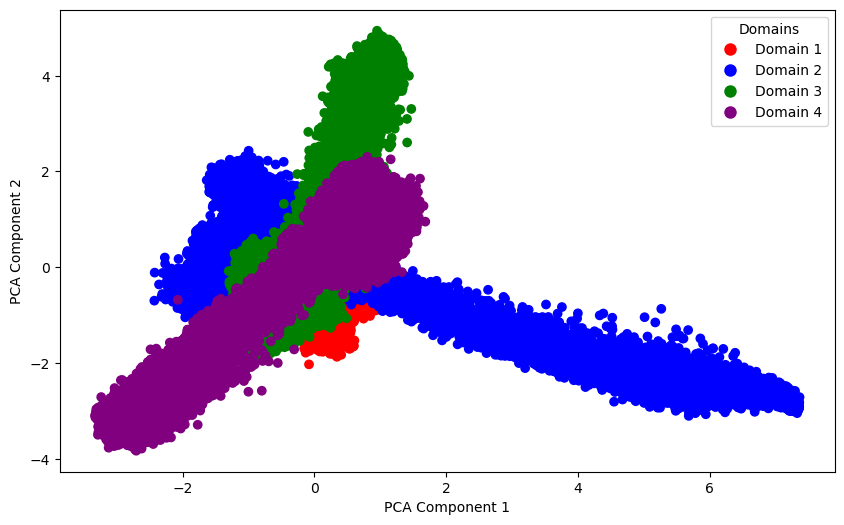

In [62]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(all_features)

# Manually assign colors to the 4 domains
domain_colors = {1: 'red', 2: 'blue', 3: 'green', 4: 'purple'}
domain_color_list = [domain_colors[label] for label in all_domain_labels]

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=domain_color_list)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in domain_colors.values()]
labels = [f'Domain {i}' for i in domain_colors.keys()]
plt.legend(handles, labels, title="Domains")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()
